### Program to read Datawell binary .BVA file
JW 03/19

Binary format described in DWTP 2.2 p.22
Hexadecimal format described in DWTP 2.1 p.19

In [1]:
%matplotlib inline

import array as arr
import binascii
import colorama
import itertools
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
#import statistics as s
import sys
import tkinter as tk

from colorama import Fore, Back, Style
from datetime import datetime, time, timedelta
from itertools import count # izip for maximum efficiency
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path, PureWindowsPath
from scipy import fftpack, signal
from scipy.signal import tukey
from scipy.stats import norm,rayleigh,skew,kurtosis
from statistics import mean
from tkinter import filedialog
from tkinter import *

Sample_frequency = "global"
Sample_rate = "global"
Sample_frequency = 2.56
Sample_rate = 1. / Sample_frequency

In [2]:
def get_file():
# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data",\
    title = "Select BVA file",filetypes = (("BVA files","*.bva"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [3]:
def Do_CRC(packet):
# Do CRC-4 checksum calculation
# See DWTP 2.1.1 pp25-26.
    key_table = [0,3,6,5,12,15,10,9,11,8,13,14,7,4,1,2]; crc = 0
    for i in range(len(packet)):
        crc = key_table[(crc^(int(packet[i][0],16))) & int('0x0f',16)]        # First nibble
        if (i > 0): 
            crc = key_table[(crc^int(packet[i][1],16)) & int('0x0f',16)]      # Second nibble

    crc = (crc^int(packet[0][1],16)) & int('0x0f',16)
    if (crc != 0): 
        print('CRC Error!',crc)
    
    return   # Do_CRC()

In [4]:
def Displacement(valu):
# Decode real time data to Displacements_List in metres
# See DWTP 2.1.1 p20. Formula 16
    
    return (0.457*math.sinh(valu/457.))

In [5]:
def Do_Timestamp(packet):
# Decode SST message vide DWTP p. 27
    Do_CRC(packet)
    Datawell_start_time = datetime(1970,1,1)
    i = int(packet[2]+packet[3]+packet[4]+packet[5],16)
    if i == 2**32-1:                   # Check for NaN
        print("Timestamp = NaN")
        Record_time = datetime.date.min
    else:
        Record_time = Datawell_start_time + timedelta(seconds=i) + timedelta(hours=10)  # Corrected from UTC to Aus EST  <<<<< STILL SOME CONFUSION ABOUT THIS
    return (Record_time)

In [6]:
def twos_complement(value, bitWidth):
    if value >= 2**bitWidth:
        # This catches value that is out of range
        raise ValueError("Value: {} out of range of {}-bit value.".format(value, bitWidth))
    else:
        return value - int((value << 1) & 2**bitWidth)

In [7]:
def Do_F20(packet):
# Decode Heave spectrum message vide DWTP p. 38-40
    Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    No_of_segments = int(packet[8],16)
    if No_of_segments == 255:                   # Check for NaN
        print("Number of segments = NaN")
    Smax = int(packet[9]+packet[10][0],16)
    if Smax == 4095:                   # Check for NaN
        print("Smax = NaN"); Smax = -99.99
    else:
        Smax = 5000*(math.exp(Smax/200.) - 1) / (math.exp(4094/200.) - 1)
    s_tilde = []
    for i in range(0,148,3):
        u = int(packet[11+i]+packet[12+i][0],16)
        s_tilde.append(Smax*(math.exp(u/200.) - 1) / (math.exp(4094/200.) - 1))
        u = int(packet[12+i][1]+packet[13+i],16)
        s_tilde.append(Smax*(math.exp(u/200.) - 1) / (math.exp(4094/200.) - 1))
##        print('{:18s}{:%Y-%m-%d %H:%M}{:6s}'.format('Heave spectrum at ',Record_time,' AEST:'))
##        print('{:27s}{:10.4f}{:2s}{:1s}{:3s}'.format('Peak value of PSD (Smax) = ',Smax,' m',chr(178),'/Hz'))
    
    return (Record_time,s_tilde,Smax,No_of_segments)    # Do_F20

In [8]:
def Do_F23(packet):
# Decode Spectrum synchronisation message vide DWTP p. 45-47
##    print('In Spectrum synchronisation routine')
    Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    Segments_used = '0000000'+packet[8][:-1]+packet[9]+packet[10]
    Sample_number = int(packet[11]+packet[12],16)        
    if Sample_number == 65536:                   # Check for NaN
        print("Timestamp = NaN")
    else:
        Hn_1 = packet[13]+packet[14][0]; Nn_1 = packet[14][1]+packet[15]; Wn_1 = packet[16]+packet[17][0]
        Hn = packet[17][1]+packet[18]; Nn = packet[19]+packet[20][0]; Wn = packet[20][1]+packet[21]
    
        Match_vector = Hn_1+Nn_1+Wn_1+Hn+Nn+Wn  # build a HEX string to be matched with WLS list
        Hn_1_sign = Displacement(twos_complement(int(Hn_1,16),12))        # Uses formula 16 from DWTP p. 20
        Nn_1_sign = Displacement(twos_complement(int(Nn_1,16),12))
        Wn_1_sign = Displacement(twos_complement(int(Wn_1,16),12))

        Hn_sign = Displacement(twos_complement(int(Hn,16),12))
        Nn_sign = Displacement(twos_complement(int(Nn,16),12))
        Wn_sign = Displacement(twos_complement(int(Wn,16),12))
    
    return (Record_time,Match_vector,Sample_number,Hn_1_sign,Nn_1_sign,Wn_1_sign,Hn_sign,Nn_sign,Wn_sign)    # Do_F23

In [9]:
def Do_F25(packet):
# Decode Directional Spectral Parameters message vide DWTP p. 51-53
    Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    No_of_segments = int(packet[8],16)
    if No_of_segments == 255:                   # Check for NaN
        print("Number of segments = NaN")
    Hs = int(packet[9]+packet[10][0],16)
    Ti = int(packet[10][1]+packet[11],16)
    Te = int(packet[12]+packet[13][0],16)
    T1 = int(packet[13][1]+packet[14],16)
    Tz = int(packet[15]+packet[16][0],16)
    T3 = int(packet[16][1]+packet[17],16)
    Tc = int(packet[18]+packet[19][0],16)
    Rp = int(packet[19][1]+packet[20],16)
    Tp = int(packet[21]+packet[22][0],16)
    Smax = int(packet[22][1]+packet[23],16)
    Theta_p = int(packet[24]+packet[25][0],16)
    Sigma_p = int(packet[25][1]+packet[26],16)
    
# Check for NaN    
    if Hs == 4095: print("Hs = NaN") 
    else: Hs = Hs/100.
    if Ti == 4095: print("Ti = NaN") 
    else: Ti = Ti/100.
    if Te == 4095: print("Te = NaN") 
    else: Te = Te/100.        
    if T1 == 4095: print("T1 = NaN") 
    else: T1 = T1/100.
    if Tz == 4095: print("Tz = NaN") 
    else: Tz = Tz/100.
    if T3 == 4095: print("T3 = NaN") 
    else: T3 = T3/100.
    if Tc == 4095: print("Tc = NaN") 
    else: Tc = Tc/100.
    if Rp == 4095: print("Rp = NaN")                 # See note with p.50 Formula 65 re Goda's peakedness
    else: Rp = Rp/4094.
    if Tp == 4095: print("Tp = NaN") 
    else: Tp = Tp/100.
    if Smax == 4095: print("Smax = NaN") 
    else: Smax = 5000*(math.exp(Smax/200.) - 1) / (math.exp(4094/200.) - 1)
    if Theta_p == 4095: print("Theta_p = NaN") 
    else: Theta_p = math.degrees(Theta_p/4095.*2.*math.pi)    # Note - Theta_p converted to Degrees!!!
    if Sigma_p == 4095: print("Sigma_p = NaN") 
    else: Sigma_p = math.degrees(Sigma_p/4095.*math.pi/2.)    # Note - Sigma_p converted to Degrees!!!
    
#    print('{:%Y-%m-%d %H:%M}{:5s}{:5.2f}{:5s}{:5.2f}{:5s}{:5.2f}{:5s}{:5.2f}{:5s}{:5.2f}{:5s}{:5.2f}{:5s}{:5.2f}' \
#        .format(Record_time,' Hs= ',Hs,' Ti= ',Ti,' Te= ',Te,' T1= ',T1,' Tz= ',Tz,' T3= ',T3,' Tc= ',Tc))
#    print('{:>27s}{:5.2f}{:5s}{:5.2f}{:7s}{:5.4f}{:10s}{:5.4f}{:1s}{:10s}{:5.4f}{:1s}' \
#        .format(' Rp= ',Rp,' Tp= ',Tp,' Smax= ',Smax,' Theta_p= ',Theta_p,chr(176),' Sigma_p= ',Sigma_p,chr(176)))
    
    return (Record_time,Hs,Ti,Te,T1,Tz,T3,Tc,Tp)    # Do_F25

In [10]:
def Do_F26(packet):
# Decode online upcrossing wave statistics message vide DWTP p. 52-57
##    print('In online upcrossing wave statistics routine')
    Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    Hmax = int(packet[8]+packet[9][0],16); THmax = int(packet[9][1]+packet[10],16); Tmax = int(packet[11]+packet[12][0],16)
    HTmax = int(packet[12][1]+packet[13],16); Havg = int(packet[14]+packet[15][0],16); Tavg = int(packet[15][1]+packet[16],16)
    Hsrms = int(packet[17]+packet[18][0],16); Nw = int(packet[18][1]+packet[19],16); Nc = int(packet[20]+packet[21][0],16)
    Epsilon = int(packet[21][1]+packet[22],16); Coverage = int(packet[23]+packet[24][0],16)
    
# Check for NaN    
    if (Hmax == 4095): print('Hmax = NaN') 
    if THmax == 4095: print('THmax = NaN')
    if Tmax == 4095: print('Tmax = NaN')
    if (HTmax == 4095): print("HTmax = NaN")
    if (Havg == 4095): print("Havg = NaN")
    if (Tavg == 4095): print("Tavg = NaN")
    if (Hsrms == 4095): print("Hsrms = NaN")
    if (Nw == 4095): print("Nw = NaN")
    if (Nc == 4095): print("Nc = NaN")
    if (Epsilon == 4095): print("Epsilon = NaN") 
    if (Coverage == 4095): print("Coverage = NaN")
    
    Hmax = Hmax / 100.; THmax = THmax / 100.; Tmax = Tmax / 100. 
    HTmax = HTmax / 100.; Havg = Havg / 100.; Tavg = Tavg / 100.
    Hsrms = Hsrms / 100.; Epsilon = Epsilon / 4094.; Coverage = Coverage / 4094. * 100. * 100.
    
#    print('{:%Y-%m-%d %H:%M}{:7s}{:5.2f}{:8s}{:5.2f}{:7s}{:5.2f}{:8s}{:5.2f}{:9s}{:5.2f}' \
#        .format(Record_time,' Hmax= ',Hmax,' THmax= ',THmax,' Tmax= ',Tmax,' HTmax= ',HTmax,' Hsrms= ',Hsrms))
#    print('{:>28s}{:4d}{:>9s}{:4d}{:>14s}{:5.4f}{:>15s}{:5.2f}{:1s}'.format(' Nw= ',Nw,' Nc= ',Nc,'Epsilon= ',Epsilon,' Coverage = ',Coverage,'%'))
    
    return (Record_time,Hmax,THmax,Tmax,HTmax,Hsrms,Nw,Nc)   # Do_F26

In [11]:
def Do_F29(packet):
# Decode Upcrossing wave height quantiles message vide DWTP p. 58-62
##    print('In Upcrossing wave height quantiles routine')
    import math
    Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    Coverage = int(packet[8]+packet[9][0],16)
    if Coverage == 4095:                   # Check for NaN
        print("Coverage = NaN"); Coverage = -99.99
    Nw = int(packet[9][1]+packet[10],16)
    Epsilon = int(packet[11]+packet[12][0],16)
    Hmax = int(packet[12][1]+packet[13],16)
    THmax = int(packet[14]+packet[15][0],16)
    H10 = int(packet[15][1]+packet[16],16)
    TH10 = int(packet[17]+packet[18][0],16)
    Hthird = int(packet[18][1]+packet[19],16)
    THthird = int(packet[20]+packet[21][0],16)
    Havg = int(packet[21][1]+packet[22],16)
    Tavg = int(packet[23]+packet[24][0],16)
    Hq0 = int(packet[24][1]+packet[25],16)
    Hq1 = int(packet[26]+packet[27][0],16)
    Hq2 = int(packet[27][1]+packet[28],16)
    
    Hq = []
    for i in range(0,30,3):
        u = int(packet[24+i][1]+packet[25+i],16)
        Hq.append(u/100.)
        u = int(packet[26+i]+packet[27+i][0],16)
        Hq.append(u/100.)
    
    # Check for NaN    
    if (Hmax == 4095): print('Hmax = NaN') 
    if THmax == 4095: print('THmax = NaN')
    if H10 == 4095: print('H10 = NaN')
    if (TH10 == 4095): print("TH10 = NaN")
    if (Hthird == 4095): print("Hthird = NaN")
    if (THthird == 4095): print("THthird = NaN")
    if (Havg == 4095): print("Havg = NaN")
    if (Tavg == 4095): print("Tavg = NaN")
        
    Hmax = Hmax / 100.; THmax = THmax / 100.
    H10 = H10 / 100.; TH10 = TH10 / 100. 
    Hthird = Hthird / 100.; THthird = THthird / 100. 
    Havg = Havg / 100.; Tavg = Tavg / 100.
    print('{:%Y-%m-%d %H:%M}{:7s}{:5.2f}{:7s}{:5.2f}{:6s}{:5.2f}{:7s}{:5.2f}{:8s}{:5.2f}{:8s}{:5.2f}{:7s}{:5.2f}{:8s}{:5.2f}'\
          .format(Record_time,' Havg= ',Havg,' H1/3= ',Hthird,' H10= ',H10,' Hmax= ',Hmax,' THavg= ',Havg,' TH1/3= ',THthird,' TH10= ',H10,' THmax= ',THmax))
    
    return ()    # Do_F29

In [12]:
def Get_Displacements(Position, Sample_number,Status, Displacements_List, wls, north, west):    
    Step_back = int(Sample_number / 2)
    n = Position[0] - Step_back + 1
    for m in range(Step_back):
 
#######################################
# Read displacement data and convert to actual values
# Refer to DWTP pp.19-21 AND Datawell Waverider RX-C4 Receiver Manual p.38
#######################################
##        line_number = Cycle_counter[m]
        displacement_record = Displacements_List[n+m]
        status_byte = displacement_record[0:1]
        Status.append(status_byte)
        record_0 = displacement_record[1:3]
        record_1 = displacement_record[3:5]
        record_2 = displacement_record[5:7]
        record_3 = displacement_record[7:9]
        record_4 = displacement_record[9:11]
        record_5 = displacement_record[11:13]
        record_6 = displacement_record[13:15]
        record_7 = displacement_record[15:17]
        record_8 = displacement_record[17:19]
        
# Build the 12-bit HEX value from the 8-bit records 0 to 8        
        h0 = record_0+record_1[0]; n0 = record_1[1]+record_2; w0 = record_3+record_4[0]
        h1 = record_4[1]+ record_5; n1 = record_6+record_7[0]; w1= record_7[1]+record_8
        
### Need to include check for NAN here !!!

# Convert the 12-bit HEX value into a signed integer, and then into actual displacement value
        h0_sign = Displacement(twos_complement(int(h0,16),12))
        n0_sign = Displacement(twos_complement(int(n0,16),12))
        w0_sign = Displacement(twos_complement(int(w0,16),12))
        h1_sign = Displacement(twos_complement(int(h1,16),12))
        n1_sign = Displacement(twos_complement(int(n1,16),12))
        w1_sign = Displacement(twos_complement(int(w1,16),12))
        
# Build lists holding each of the displacement values
        wls.append(h0_sign); wls.append(h1_sign) 
        north.append(n0_sign); north.append(n1_sign)
        west.append(w0_sign); west.append(w1_sign)

    return(Status,wls,north,west)    # Get_Displacements

In [13]:
def Calc_MWL(wls):
# Calculate correction for mean water level (vide Goda p.320)    
    j = len(wls)
    N0 = 0; N1 = 0; N2 = 0; Y0 = 0; Y1 = 0; Y2 = 0
    for __ in range(0,j):
        N0 = N0 + __**0; N1 = N1 + __**1; N2 = N2 + __**2
        Y0 = Y0 + __**0*wls[__]; Y1 = Y1 + __**1*wls[__]; Y2 = Y2 + __**2*wls[__]    

    A0 = (N2*Y0 - N1*Y1)/(N0*N2 - N1**2); A1 = (N0*Y1 - N1*Y0)/(N0*N2 - N1**2)
    
    wls_mean = 0
    for __ in range(0,j):
        wls_mean = A0 + A1*__
            
    wls = [x+wls_mean for x in wls]   # apply the correction to the wls

    return(wls)    # Calc_MWL(wls)

In [14]:
def calc_frequencies():
    fk = []
    for k in range(100):
        if k<46: fk.append(0.025 + 0.005*k)
        if k>=46 and k<79: fk.append(-0.20 + 0.010*k)
        if k>=79: fk.append(-0.98 + 0.020*k)
    
    return(fk)    # calc_frequencies()    

In [15]:
def print_spectra(fk,s_tidle,dirn,spread):
    print('{:36s}'.format('Freq.    Heave       Dirn.    Spread'))
    for k in range(100):
        print('{:>02.3f}{:3s}{:>05.6f}{:3s}{:>05.4f}{:3s}{:>05.4f}'.format(fk[k],'   ',s_tidle[k],'   ',dirn[k],'   ',spread[k]))
    return()    # print_spectra

In [16]:
def calc_spectral_parameters(wls):
##    Sample_frequency = 2.56     # vide Datawell Library Manual P.40
    f_Mk4 = calc_frequencies()    # calculate frequency values for the Mk4 wave buoy
                    
##    f1, Pden1 = sp.signal.periodogram(wls[0:4096],Sample_frequency,scaling='density',window=tukey(4096))
    f2, Pden2 = sp.signal.welch(wls,fs=Sample_frequency,window='hanning',nperseg=512,noverlap=256,\
            nfft=None,detrend='constant',return_onesided=True,scaling='density',axis=-1)
                       
# Peak frequency and period of banded spectra (Fp)                
    Fp2 = f2[Pden2.argmax()]; Tp2 = 1/Fp2

    return(f2,Pden2,Tp2)   # calc_spectral_parameters()

In [17]:
def Mk4_moments(f_Mk4, Spectra):
# routine to calculate the spectral moments: m0; m1; and m2 from an input Mk4 spectra
    
    Ax1 = (f_Mk4[45] - f_Mk4[0]) / 45
    Ax2 = (f_Mk4[78] - f_Mk4[45]) / 32
    Ax3 = (f_Mk4[99] - f_Mk4[78]) / 21 
    
# calc spectral moments m0, m1, and m2
    s00 = 0; s10 = 0; s20 = 0; m0 = 0
    s01 = 0; s11 = 0; s21 = 0; m1 = 0
    s02 = 0; s12 = 0; s22 = 0; m2 = 0
    for j in range(1,44):
        s00 += Spectra[j]
        s01 += f_Mk4[j] * Spectra[j]
        s02 += f_Mk4[j]**2 * Spectra[j]
    m0 = 0.5*Ax1*(Spectra[0] + 2*s00 + Spectra[45])
    m1 = 0.5*Ax1*(f_Mk4[0]*Spectra[0]+2*s01+f_Mk4[45]*Spectra[45])
    m2 = 0.5*Ax1*(f_Mk4[0]**2*Spectra[0]+2*s02+f_Mk4[45]**2*Spectra[45])
    
    for j in range(46,77):
        s10 += Spectra[j]
        s11 += f_Mk4[j] * Spectra[j]
        s12 += f_Mk4[j]**2 * Spectra[j]
    m0 += 0.5*Ax2*(Spectra[45] + 2*s10 + Spectra[78])
    m1 += 0.5*Ax2*(f_Mk4[45]*Spectra[45]+2*s11+f_Mk4[78]*Spectra[78])
    m2 += 0.5*Ax2*(f_Mk4[45]**2*Spectra[45]+2*s12+f_Mk4[78]**2*Spectra[78])
    
    for j in range(79,98):
        s20 += Spectra[j]
        s21 += f_Mk4[j] * Spectra[j]
        s22 += f_Mk4[j]**2 * Spectra[j]
    m0 += 0.5*Ax3*(Spectra[78] + 2*s20 + Spectra[99])
    m1 += 0.5*Ax3*(f_Mk4[78]*Spectra[78]+2*s21+f_Mk4[99]*Spectra[99])
    m2 += 0.5*Ax3*(f_Mk4[78]**2*Spectra[78]+2*s22+f_Mk4[99]**2*Spectra[99])
    
    return (m0,m1,m2)   # Mk_4_moments()

In [18]:
def get_parameters_Mk4(f,Spectra):
    m0,m1,m2 = Mk4_moments(f,Spectra)    
    
# calc wave parameters Hm0, Hrms, T01, T02
    Hm0 = 4*np.sqrt(m0); Hrms = np.sqrt(2)/2*Hm0
    T01 = m0/m1; T02 = np.sqrt(m0/m2)
    
# identify spectral peak and frequency as peak    
    max_frequency = [k for k, j in enumerate(Spectra) if j == np.max(Spectra)]
    Fp = f_Mk4[max_frequency[0]]; Tp = 1/Fp 

    return(Hm0,Hrms,T01,T02,Tp,Fp)   # get_parameters_Mk4()

In [19]:
def Plot_spectra(f,Spectra,f2,Pden2,Date,Hm0,Hrms,T01,T02,Tp,Fp):
    max_Spectra = max(max(Spectra),max(Pden2))

    plt.figure(figsize=(20,10)) ###, dpi= 80, facecolor='w', edgecolor='k')
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.title(Date,fontsize=16)  
    plt.xlabel('Frequency (Hz)',fontsize=16); plt.xlim(0, 1) # Display Frequency on X-axis
    plt.ylim(bottom=0, top=max_Spectra)
    plt.ylabel('Spectral density ($m^2$/Hz)',fontsize=16)
    
    plt.text(0.45, max_Spectra*0.95, "Welch's method",horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.90, 'Hm0  = '+"%.2f" % Hm0+'m',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.85, 'Hrms = '+"%.2f" % Hrms+'m',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.80, 'T01  = '+"%.2f" % T01+'s',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.75, 'T02  = '+"%.2f" % T02+'s',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.70, 'Tp   = '+"%.2f" % Tp+'s',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.65, 'Fp   = '+"%.2f" % Fp+'Hz',horizontalalignment='left',verticalalignment='center',fontsize=15)

    plt.plot(f,Spectra,'-b',linewidth=2,label = 'Datawell')
    plt.fill(f,Spectra,c='xkcd:light sky blue')
    plt.plot(f2,Pden2,'-r',linewidth=1,label = "Welch's method")
    
    plt.legend(loc='upper right',fontsize=16,frameon=False)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return()   # Plot_spectra()

In [20]:
def Plot_wls(wls,Below,Hsig,Hmax,Tz,Tp2,Record_time,spikes):
# plot time-series of current half-hour on four plots (each 450s wide).
# this plot shows WSEs and those points used to determine zero-upcrossing waves
    spikes = spikes[0][:]    # convert tuple to array
    wls = np.array(wls)
    Times = np.linspace(0,1800,num=4608) # Populate an array with 4608 points at 1/2.56 spacing (i.e. 1800s)
    if(len(wls)<len(Times)): 
        diff = len(Times) - len(wls)
        Times = Times[0:len(wls)]    # Identified an error in wls, so chop end off Times
        print('ALERT: ',diff,' water-level values missing from file!')
    plt.figure(figsize=(10,15),dpi=100)
    plt.subplot(4, 1, 1)
    plt.title(Record_time,fontsize=10)
    plt.xlabel('Time from start of record (s)')
    x = 0; y = 1152
    top_val = round(Hmax+0.5)/2
        
    plt.xlim(left = 0,right = 450); bottom_val = -top_val
    plt.ylim(bottom = bottom_val,top = top_val)
    bb = (np.abs(Below-y)).argmin()
##  plt.plot(Times[Below[0:bb+1]],wls[Below[0:bb+1]],linewidth=0,c='xkcd:orangered',marker='o',markersize=4)
    if spikes.size:
        bb1 = spikes[np.nonzero((spikes>= x)&(spikes< y))]
        if bb1.size:
            for __ in bb1:
                plt.plot(Times[__],wls[__],linewidth=0,marker='o',markeredgecolor='r',markerfacecolor='none',markersize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.plot(Times[x:y+5],wls[x:y+5],linewidth=0.75,marker='x',markersize=1,c='xkcd:azure')
    plt.plot([Times[x],Times[y+5]],[0.05,0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.plot([Times[x],Times[y+5]],[-0.05,-0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.text(1, top_val*0.8, '  Hsig = '+"%.2f" % Hsig+'m'+'    Hmax = '+"%.2f" % Hmax+'m'+\
             '    Tz = '+"%.2f" % Tz+'s'+'    Tp = '+"%.2f" % Tp+'s')
    plt.grid(True,linewidth=0.5)

    plt.subplot(4, 1, 2)
#    plt.title(Record_time,fontsize=15)
    plt.xlabel('Time from start of record (s)')
    x = 1152; y = 2304
    plt.xlim(left = 450,right = 900)
    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
    aa = (np.abs(Below-x)).argmin()
    bb = (np.abs(Below-y)).argmin()
##  plt.plot(Times[Below[aa-1:bb+1]],wls[Below[aa-1:bb+1]],linewidth=0,c='xkcd:orangered',marker='o',markersize=4)
    if spikes.size:
        bb1 = spikes[np.nonzero((spikes>= x)&(spikes< y))]
        if bb1.size:
            for __ in bb1:
                plt.plot(Times[__],wls[__],linewidth=0,marker='o',markeredgecolor='r',markerfacecolor='none',markersize=10)
    plt.plot(Times[x-5:y+5],wls[x-5:y+5],linewidth=0.75,marker='x',markersize=1,c='xkcd:azure')
    plt.plot([Times[x-5],Times[y+5]],[0.05,0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.plot([Times[x-5],Times[y+5]],[-0.05,-0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.tick_params(axis='both',which='major',labelsize=10)
    plt.grid(True,linewidth=0.5)

    plt.subplot(4, 1, 3)
#    plt.title(Record_time,fontsize=15)1
    plt.xlabel('Time from start of record (s)')
    x = 2304; y = 3456
    plt.xlim(left = 900,right = 1350)
    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
    aa = (np.abs(Below-x)).argmin()
    bb = (np.abs(Below-y)).argmin()
##  plt.plot(Times[Below[aa-1:bb+1]],wls[Below[aa-1:bb+1]],linewidth=0,c='xkcd:orangered',marker='o',markersize=4)
    if spikes.size:
        bb1 = spikes[np.nonzero((spikes>= x)&(spikes< y))]
        if bb1.size:
            for __ in bb1:
                plt.plot(Times[__],wls[__],linewidth=0,marker='o',markeredgecolor='r',markerfacecolor='none',markersize=10)
    plt.plot(Times[x-5:y+5],wls[x-5:y+5],linewidth=0.75,marker='x',markersize=1,c='xkcd:azure')
    plt.plot([Times[x-5],Times[y+5]],[0.05,0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.plot([Times[x-5],Times[y+5]],[-0.05,-0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.tick_params(axis='both',which='major',labelsize=10)
    plt.grid(True,linewidth=0.5)

    plt.subplot(4, 1, 4)
#    plt.title(Record_time,fontsize=15)
    plt.xlabel('Time from start of record (s)')
    x = 3456; y = len(wls)-1
    plt.xlim(left = 1350,right = 1800)
    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
    aa = (np.abs(Below-x)).argmin()
    bb = (np.abs(Below-y)).argmin()
##  plt.plot(Times[Below[aa-1:]],wls[Below[aa-1:]],linewidth=0,c='xkcd:orangered',marker='o',markersize=4)
    if spikes.size:
        bb1 = spikes[np.nonzero((spikes>= x)&(spikes< y))]
        if bb1.size:
            for __ in bb1:
                plt.plot(Times[__],wls[__],linewidth=0,marker='o',markeredgecolor='r',markerfacecolor='none',markersize=10)
    plt.plot(Times[x-5:y],wls[x-5:y],linewidth=0.75,marker='x',markersize=1,c='xkcd:azure')
    plt.plot([Times[x-5],Times[y]],[0.05,0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.plot([Times[x-5],Times[y]],[-0.05,-0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.tick_params(axis='both',which='major',labelsize=10)
    plt.grid(True,linewidth=0.5)
    
    plt.show()
    
    return()   # Plot_wls

In [21]:
def Plot_heave_north_west(wls,north,west,Hsig,Hmax,Tz,Tp2,Record_time,spikes):
# plot time-series of current half-hour on four plots (each 450s wide).
# this plot shows WSEs and those points used to determine zero-upcrossing waves
    plt.figure(figsize=(10,15),dpi=100)
    plt.subplot(3, 1, 1)
    wls = np.array(wls)
    spikes = np.where(np.abs(wls) > np.median((wls)+3.5*np.std(wls)))    # NOTE - used Median instead of Mean (as median is more resistant to outliers)
    Times = np.linspace(0,1800,num=4608) # Populate an array with 4608 points at 1/2.56 spacing (i.e. 1800s)
    wls_spike_locations = np.array(Times[spikes[:][0]])
    np.set_printoptions(precision=2)
    spikes = spikes[0][:]
    if(len(wls_spike_locations) > 0): 
        print('ALERT: Possible spikes in the Heave data at times:',wls_spike_locations)
        wls = np.delete(wls,spikes[:][0])
    if(len(wls)<len(Times)): 
        diff = len(Times) - len(wls)
        Times = Times[0:len(wls)]    # Identified an error in wls, so chop end off Times
        print('ALERT: ',diff,' Heave values missing from file!')
    
    plt.title(Record_time,fontsize=10)
    plt.xlabel('Heave displacement')
    plt.xlim(left = 0,right = 1800)
#    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
#    plt.ylim(bottom = 0-round(max(np.abs(wls))),top = round(max(np.abs(wls))))
    plt.ylim(bottom = 0-round(max(max(wls),abs(min(wls)))+0.5),top = round(max(max(wls),abs(min(wls)))+0.5))
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.plot(Times,wls,linewidth=0.5)
    if spikes.size:
        for __ in spikes:
                plt.plot(Times[__],wls[__],linewidth=0,marker='o',markeredgecolor='r',markerfacecolor='none',markersize=5)
    plt.plot([Times[0],Times[-1]],[0.05,0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.plot([Times[0],Times[-1]],[-0.05,-0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.text(1, max(wls)*0.8, '  Hsig = '+"%.2f" % Hsig+'m'+'    Hmax = '+"%.2f" % Hmax+'m'+\
             '    Tz = '+"%.2f" % Tz+'s'+'    Tp = '+"%.2f" % Tp+'s')
    plt.grid(True,linewidth=0.5)  
    
    plt.subplot(3, 1, 2)
    spikes = np.where(np.abs(north) > np.median((north)+3.5*np.std(north)))    # NOTE - used Median instead of Mean (as median is more resistant to outliers)
    north_spike_locations = np.array(Times[spikes[:][0]])
    np.set_printoptions(precision=2)
    spikes = spikes[0][:]
    if (len(north_spike_locations) > 0): 
        print('ALERT: Possible spikes in the North data at times:',north_spike_locations)
        north = np.delete(north,spikes[:][0])
    north = np.array(north)
    Times = np.linspace(0,1800,num=4608) # Populate an array with 4608 points at 1/2.56 spacing (i.e. 1800s)
    if(len(north)<len(Times)): 
        diff = len(Times) - len(north)
        Times = Times[0:len(north)]    # Identified an error in wls, so chop end off Times
        print('ALERT: ',diff,' North values missing from file!')

#    plt.title(Record_time,fontsize=15)
    plt.xlabel('North displacement')
    plt.xlim(left = 0,right = 1800)
    plt.ylim(bottom = 0-round(max(max(north),abs(min(north)))+0.5),top = round(max(max(north),abs(min(north)))+0.5))
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.plot(Times,north,linewidth=0.5,c='xkcd:tan')
    if spikes.size:
        for __ in spikes:
                plt.plot(Times[__],north[__],linewidth=0,marker='o',markeredgecolor='r',markerfacecolor='none',markersize=5)
    plt.plot([Times[0],Times[-1]],[0.05,0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.plot([Times[0],Times[-1]],[-0.05,-0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.grid(True,linewidth=0.5)

    plt.subplot(3, 1, 3)
    spikes = np.where(np.abs(west) > np.median((west)+3.5*np.std(west)))    # NOTE - used Median instead of Mean (as median is more resistant to outliers)
    west_spike_locations = np.array(Times[spikes[:][0]])
    np.set_printoptions(precision=2)
    spikes = spikes[0][:]
    if (len(west_spike_locations) > 0): 
        print('ALERT: Possible spikes in the West data at times:',west_spike_locations)
        west = np.delete(west,spikes[:][0])
    west = np.array(west)
    Times = np.linspace(0,1800,num=4608) # Populate an array with 4608 points at 1/2.56 spacing (i.e. 1800s)
    if(len(west)<len(Times)): 
        diff = len(Times) - len(west)
        Times = Times[0:len(west)]    # Identified an error in wls, so chop end off Times
        print('ALERT: ',diff,' West values missing from file!')

#    plt.title(Record_time,fontsize=15)
    plt.xlabel('West displacement')
    plt.xlim(left = 0,right = 1800)
    plt.ylim(bottom = 0-round(max(max(west),abs(min(west)))+0.5),top = round(max(max(west),abs(min(west)))+0.5))
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.plot(Times,west,linewidth=0.5,c='xkcd:salmon')
    if spikes.size:
        for __ in spikes:
                plt.plot(Times[__],west[__],linewidth=0,marker='o',markeredgecolor='r',markerfacecolor='none',markersize=5)
    plt.plot([Times[0],Times[-1]],[0.05,0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.plot([Times[0],Times[-1]],[-0.05,-0.05],linewidth=0.25,c='xkcd:aquamarine')
    plt.grid(True,linewidth=0.5)
   
    plt.show()
    
    return()

In [22]:
def Do_Histogram(x_val,Record_time):
    binwidth = 0.2

# Fit a normal distribution to the data:
    mu, std = norm.fit(x_val)
    spike = np.median(x_val) + std*3.5

# Plot the histogram.
    plt.figure(figsize=(15,10))
    plt.hist(x_val, bins=np.arange(round(min(x_val)),round(max(x_val)) + binwidth,binwidth),\
             density=1,edgecolor='black',facecolor='xkcd:aquamarine',alpha=0.5)

# Plot the PDF.
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, color='orange',linewidth=4)
    plt.xlabel('Histogram of Water surface elevations')
    plt.ylabel('Probability')
    plt.title(Record_time,fontsize=10)
    
    plt.text(spike,0.225, r'3.5$\sigma$',fontsize=20,horizontalalignment='center')
    plt.plot([spike,spike],[0.0,0.2],color="black",dashes=[5, 5, 5, 5])
    plt.text(-spike,0.225, r'-3.5$\sigma$',fontsize=20,horizontalalignment='center')
    plt.plot([-spike,-spike],[0.0,0.2],color="black",dashes=[5, 5, 5, 5])
    
    pos_spikes = sum(x_val>spike)
    if pos_spikes > 0: 
        if pos_spikes == 1:
            spike_txt = ' spike '
        else:
            spike_txt = ' spikes '
        plt.text(spike,ymax*0.8,"%3d" % pos_spikes+spike_txt+'> 3.5$\sigma$',horizontalalignment='center',fontsize=10)
    neg_spikes = sum(x_val<-spike)
    if neg_spikes > 0:
        if neg_spikes == 1:
            spike_txt = ' spike '
        else:
            spike_txt = ' spikes '
        plt.text(-spike,ymax*0.8,"%3d" % neg_spikes+spike_txt+'< -3.5$\sigma$',horizontalalignment='center',fontsize=10)
# Calculate Skewness and Kurtosis - refer Goda p.298 (9.129) and (9.130) plus accompanying discussion 9.5.1.
    plt.text(xmin*0.95, ymax*0.75,'Skewness = '+"%.2f" % skew(x_val),fontsize=12)
    plt.text(xmin*0.95, ymax*0.70,'Kurtosis = '+"%.2f" % kurtosis(x_val,fisher=False),fontsize=12)
   
    plt.show()
    
    return()    # Do_Histogram() 

In [23]:
def Do_Rayleigh(waves,Record_time,Hsig,Hrms,Hmax):
    import collections
    plt.figure(figsize=(15,10))
    mean, var, skew, kurt = rayleigh.stats(moments='mvsk')
    x = np.linspace(rayleigh.ppf(0.01),rayleigh.ppf(0.99),100)

# Plot histogram of wave heights
    i=0;nbins = []
    while i<Hmax+0.2:
        nbins.append(i)
        i += 0.2
    i+= 0.2 
    inds = np.digitize(waves,nbins)
    c = collections.Counter(inds)
    a = sorted(c.items())
    bin_count = []
    i = 0; j = 0
    while i <=len(nbins)-2:
        if a[:][j][0]-1 == i:
            bin_count.append(a[:][j][1])
            j += 1
        else:
            bin_count.append(0)
        i+=1
    
    plt.xaxis = (0,max(nbins))
    plt.hist(waves,bins=nbins,density='normed',range=(0,max(waves)),edgecolor='black',facecolor='xkcd:aquamarine',alpha=0.5)
    for i in range(len(nbins)-1):
        plt.text(nbins[i]+0.075,0.05,bin_count[i],fontsize=14)
        
# Plot Rayleigh distribution
##    plt.plot(x, rayleigh.pdf(x,0,1),'r-', lw=4, alpha=0.6,label='Rayleigh')
  
# Do a Rayleigh distribution based on Hrms  
    x1 = np.linspace(0,Hmax,100)
    p_h = []
    for i in x1:
        p_h.append(2*i/Hrms**2*np.exp(-(i/Hrms)**2)) # from Massel p192 (6.43) and Karimpour p.25 (3.13)
    plt.text(nbins[len(nbins)-4], max(p_h)*0.8, 'Hmax = '+"%.2f" % Hmax+'m',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(nbins[len(nbins)-4], max(p_h)*0.75, 'No. of waves = '+"%.2d" % len(waves),horizontalalignment='left',verticalalignment='center',fontsize=15)

    plt.plot(x1,p_h, lw=4,label='Rayleigh (Hrms)')

# Plot Normal distribution
    y_pdf=sp.stats.norm.pdf(x,np.mean(waves),np.std(waves))
    plt.plot(x,y_pdf, lw=4,label='Normal distribution')
    
    plt.xlabel('Wave height (m)')
    plt.ylabel('Probability')
    plt.legend(frameon=False)
    plt.title(F20_time,fontsize=10)

# Display wave parameter representations on Rayleigh distribution     
    plt.text(Hsig,0.225, r'Hsig',fontsize=20,horizontalalignment='center')
    plt.plot([Hsig,Hsig],[0.0,0.2],color="black",dashes=[5, 5, 5, 5])
    plt.text(Hrms,0.225, r'Hrms',fontsize=20,horizontalalignment='center')
    plt.plot([Hrms,Hrms],[0.0,0.2],color="black",dashes=[5, 5, 5, 5])
    plt.text(Hmax,0.225, r'Hmax',fontsize=20,horizontalalignment='center')
    plt.plot([Hmax,Hmax],[0.0,0.2],color="black",dashes=[5, 5, 5, 5])
    
    plt.show()

    return()    # Do_Rayleigh() 

In [24]:
def Plot_velocities(wls):

    velocities = [(x - wls[i - 1])*2.56 for i, x in enumerate(wls)][1:]
    limit = np.median((velocities)+3.5*np.std(velocities))
    offset = max(abs(min(velocities)),max(velocities))
    vector =([np.sqrt(wls[i]**2+velocities[i]**2) for i in range(len(velocities))])

    plt.figure(figsize=(6,6),dpi=100)   
    plt.xlabel("WSE's (m)")
    plt.ylabel('Velocity (m/s)')
    plt.title("WSE's v Velocity",fontsize=10)
    plt.xlim(left=-offset*1.05,right=offset*1.05)
    plt.ylim(bottom=-offset*1.05,top=offset*1.05)
    plt.grid(True)

    color = ['red' if x >= limit or x<=-limit else 'lightgreen' for x in velocities]

    wls_1 = wls[1:]
    plt.scatter(wls_1,velocities,marker='o',c=color,s=9)
    plt.show()   
    
    return()

In [25]:
###    3d Plot    ###
def set_aspect_equal_3d(ax):
    """Fix equal aspect bug for 3D plots."""

    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)

    plot_radius = max([abs(lim - mean_)
                       for lims, mean_ in ((xlim, xmean),
                                           (ylim, ymean),
                                           (zlim, zmean))
                       for lim in lims])

    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

def Do_3d (wls,north,west,Record_time):
    mpl.rcParams['legend.fontsize'] = 10

    mu_x, std_x = norm.fit(west)
    spike_x = np.median(west) + std_x*3.5

    mu_y, std_y = norm.fit(north)
    spike_y = np.median(north) + std_y*3.5

    mu_z, std_z = norm.fit(wls)
    spike_z = np.median(wls) + std_z*3.5

    fig = plt.figure()
    fig=plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')

    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
    x = west
    y = north
    z = wls

    color = ['red' if x <= 0 else 'green' for x in z]

    ax.plot(x, y, z, linewidth=0.2,c='xkcd:cement',label=Record_time)
    ax.scatter(x, y, z, c=color, marker='o',s=5)   

    ax.legend()
    ax.set_xlabel('East-West Displacement (m)')
    ax.set_ylabel('North-South Displacement (m)')
    ax.set_zlabel('Heave Displacement (m)')

    ax.set_aspect('equal') 

    set_aspect_equal_3d(ax)
    plt.show()
    
    return()    # 3d_Plot

In [26]:
def Do_polar(wls,north,west,Record_time):
    r = np.sqrt(np.asarray(west, dtype=np.float32)**2+np.asarray(north, dtype=np.float32)**2)
    t = np.arctan2(np.asarray(north, dtype=np.float32),np.asarray(west, dtype=np.float32))
    fig = plt.figure()
    fig=plt.figure(figsize=(10,10))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_direction(-1) 
    ax.set_theta_zero_location("N")
    color = ['red' if x <= 0 else 'lightgreen' for x in wls]
    ax = plt.plot(t, r, alpha=0.75,linewidth=0.2,c='xkcd:cement',label=Record_time)
    ax = plt.scatter(t, r, c=color, marker='o',s=5,alpha=0.75)
    plt.show()
    
    return()

In [27]:
def get_parameters_Mk4(f,Spectra,Record_time):
    m0,m1,m2 = Mk4_moments(f,Spectra)    
    
# calc wave parameters Hm0, Hrms, T01, T02
    Hm0 = 4*np.sqrt(m0); Hrms = np.sqrt(2)/2*Hm0
    T01 = m0/m1; T02 = np.sqrt(m0/m2)
    
    # identify spectral peak and frequency as peak    
    max_frequency = [k for k, j in enumerate(Spectra) if j == np.max(Spectra)]
    Fp = f[max_frequency[0]]; Tp = 1/Fp 
    
    print('{:%Y-%m-%d %H:%M}{:5s}{:<5.2f}{:6s}{:<5.2f}{:5s}{:<5.2f}{:5s}{:<5.2f}{:4s}{:<5.2f}'\
        .format(Record_time,' Hm0=',Hm0,' Hrms=',Hrms,' T01=',T01,' T02 ',T02,' Tp=',Tp))

    return(Hm0,Hrms,T01,T02,Tp,Fp)   # get_parameters_Mk4()

In [28]:
def find_median(sorted_list):
# routine to calculate Median and first and third Quartiles in order to apply IQR Rule to wls.    
    indices = []

    list_size = len(sorted_list)
    median = 0

    if list_size % 2 == 0:
        indices.append(int(list_size / 2) - 1)  # -1 because index starts from 0
        indices.append(int(list_size / 2))

        median = (sorted_list[indices[0]] + sorted_list[indices[1]]) / 2
        pass
    else:
        indices.append(int(list_size / 2))

        median = sorted_list[indices[0]]
        pass

    return(median,indices)

In [29]:
def Medcouple (wls,Q1,Q3,IQR):
    import statsmodels
    from statsmodels.stats.stattools import medcouple

    # Following code based on IQR Rule and discussion at:
    # https://stats.stackexchange.com/questions/13086/is-there-a-boxplot-variant-for-poisson-distributed-data#13429
    M = medcouple(wls)
    if M >= 0:
        lower = Q1-math.exp(-4.0*M)*2*IQR
        upper = Q3+math.exp(3.0*M)*2*IQR
    else:
        lower = Q1-math.exp(-3.0*M)*2*IQR
        upper = Q3+math.exp(4.0*M)*2*IQR

    return(max(upper,abs(lower)))

In [30]:
def Do_time_domain(wls,Record_time,Tp2):
    wls = np.array(wls)

# Identify and report where Repaired values; Bad values; and Spikes are in record
    Times = np.linspace(0,1800,num=4608)
    Repaired_vals = [i for i,x in enumerate([x[0:1]for x in Displacements_List[Position[0]:Position[0]+2304]]) if x == '=']
    Repaired_vals = np.array(Repaired_vals)
    np.set_printoptions(precision=2)
    if len(Repaired_vals)>0: print('Repaired values at ',Times[Repaired_vals[:]])
                    
    Bad_vals = [i for i,x in enumerate([x[0:1]for x in Displacements_List[Position[0]:Position[0]+2304]]) if x == '!']
    Bad_vals = np.array(Bad_vals)
    np.set_printoptions(precision=2)
    if len(Bad_vals)>0: print('WARNING: Bad values at ',Times[Bad_vals[:]])

# NOTE - used Median for spike detection instead of Mean (as Median is more resistant to influence of outliers)        
##    spikes = np.where(np.abs(wls) > np.median((wls)+3.5*np.std(wls)))    
#######################################
    sorted_wls = np.sort(wls)
    median, median_indices = find_median(sorted_wls)
    Q1, Q1_indices = find_median(sorted_wls[:median_indices[0]])
    Q3, Q3_indices = find_median(sorted_wls[median_indices[-1] + 1:])
    IQR = Q3-Q1
    spikes = np.where(np.abs(wls) > Medcouple(wls,Q1,Q3,IQR)) 
#######################################                      
    spike_locations = np.array(Times[spikes[:][0]])
    np.set_printoptions(precision=2)
    if (len(spike_locations) > 0): 
        print(Fore.RED +'ALERT: Possible spikes in the data at times:',spike_locations)
        wls = np.delete(wls,spikes[:][0])
    
# Identify zero-crossing points to be used in identifying individual waves
# From Goda 2nd. edition p.321 10.10, and also includes test for zero-crossing where wl = 0
    zero_crossing = []; valid_zero_crossing = []
    for __ in range(len(wls)-2):
        if (wls[__]*wls[__+1] < 0 and wls[__+1] > 0) or (wls[__] == 0 and wls[__-1] < 0 and wls[__+1] > 0):
            zero_crossing.append(__)    
    
    zero_crossing = np.array(zero_crossing)
    waves = []; Periods = []; Wave_num = 0; Crest_num = 0
    i = 0; j = i+1
    try:
        while i in range(len(zero_crossing)-2):
            wave = wls[zero_crossing[i]+1:zero_crossing[j]+1]
            crest = max(wave); trough = min(wave)

            if i > 0 and ((crest <= 0.05 and trough >= -0.05) or crest <= 0.05):  
# No wave, or no crest above threshold
# So, we need to step back to the start of the previous wave for the crest and trough details. 
# Wave period needs to be expanded to include period of last wave AND period of this event too.
    ##            print('{:5d}{:31s}{:10.4f}{:10.4f}'.format(i,'   No wave or no crest detected',crest,trough))
    ##            print('--------------------------------------------------')
                waves = waves[:-1]                 # remove last recorded wave from list
                Periods = Periods[:-1]             # remove last recorded Period from list
                Wave_num -=1                       # reduce count of number of waves by 1
                if len(valid_zero_crossing) > 0: del valid_zero_crossing[-1]        # remove this zero crossing from list as wave declared invalid
                if crest <= 0.05: Crest_num -=1    # reduce count of number of Crests by 1
                i -= 1
            elif (trough >= -0.05):                # No trough below threshold
    ##            print('{:5d}{:22s}{:10.4f}{:10.4f}'.format(i,'   No trough detected ',crest,trough))
    ##            print('--------------------------------------------------')
                j += 1
            else:                                  # wave exceeds thresholds, so process it
                Height = crest+abs(trough)
                waves.append(Height)
                valid_zero_crossing.append(zero_crossing[i])  # keep record of zero-crossings for valid waves      
    # get the individual wave periods.
    # the sums of increments of wse's plus linear interpolation of the zero-crossing end bits            
                if wls[zero_crossing[i]]!=0:
                    H1 = wls[zero_crossing[i]+1]+abs(wls[zero_crossing[i]])
                    h1 = abs(wls[zero_crossing[i]])
                    delta_h1= float(h1*0.39)/float(H1)
                else:
                    delta_h1=0      

                if wls[zero_crossing[j]]!=0:
                    H2 = wls[zero_crossing[j]+1]+abs(wls[zero_crossing[j]+1])
                    h2 = abs(wls[zero_crossing[j]+1])
                    delta_h2= float(h2*0.39)/float(H2)
                else:
                    delta_h2=0

                period = Times[zero_crossing[j]+1]-Times[zero_crossing[i]+1]-delta_h1+delta_h2
                Periods.append(period)
    #            print('{:10d}{:10.4f}{:10.4f}{:10.4f}{:10.4f}'.format(i+1,wls[zero_crossing[i]],wls[zero_crossing[j]],Height,period))
    #            print('{:5d}{:3s}{:10.4f}{:3s}{:10.4f}{:3s}{:10.4f}{:3s}{:10.4f}'.format(i+1,'H1=',H1,'h1=',h1,'H2=',H2,'h2=',h2))
                Wave_num +=1; Crest_num += 1
    ##            print('{:5d}{:5d}{:10.4f}{:10.4f}'.format(i,Wave_num,Height,period))
                i=j; j+=1    # can now move to next zero-crossing wave
    except IndexError:
        pass       
# Sort the waves and determine Time-Domain heights
    waves = np.asarray(waves)
    sorted_waves = np.sort(waves)[::-1]
    Hmax = max(sorted_waves)
    Hmean = mean(sorted_waves)
    Hsig = mean(sorted_waves[0:math.trunc(len(sorted_waves)/3.3333)])
    H10 = mean(sorted_waves[0:math.trunc(len(sorted_waves)/10.0)])
    Hrms = np.sqrt(np.mean(sorted_waves**2))

# Get Time-Domain periods
    Periods = np.asarray(Periods)
    Tmax = max(Periods)
    Tz = mean(Periods)
    THmax = Periods[np.abs(waves - Hmax).argmin()]
    THsig = Periods[np.abs(waves - Hsig).argmin()]
    TH10 = Periods[np.abs(waves - H10).argmin()]

    print('{:%Y-%m-%d %H:%M}{:6s}{:<5.2f}{:6s}{:<5.2f}{:6s}{:<5.2f}{:4s}{:<5.2f}{:6s}{:<5.2f}{:4s}{:<5.2f}{:6s}{:<5.2f}{:11s}{:<4d}\
    '.format(Record_time,' Hsig=',Hsig,' Hrms=',Hrms,' Hmax=',Hmax,' Tz=',Tz,' THsig=',THsig,' Tp=',Tp2,' Tmax=',Tmax,' Wave Num.=',Wave_num))
    valid_zero_crossing = np.array(valid_zero_crossing)
    
    return(valid_zero_crossing,Hmean,Hsig,Hmax,Tz,THsig,Tp2,Tmax,waves,spikes)   # Do_time_domain()

In [31]:
def Do_error_checks(wls,Hsig,Hmax,Hrms,Hm0,THsig,T02,Tz,Tp,Tzmax):
    from itertools import groupby

# look for consecutive WSEs the same - Warn if >= 4
    grouped_wls = [(k, sum(1 for i in g)) for k,g in groupby(wls)]
 # Or (k, len(list(g))), but that creates an intermediate list
#    print('Warning - ',np.around(max(grouped_wls)[0],decimals=1),' occurred on ',max(grouped_wls)[1],' consecutive WSEs')
    if max(grouped_wls)[1] >= 4:
        print('Warning - ',np.around(max(grouped_wls)[0],decimals=1),' occurred on ',max(grouped_wls)[1],' consecutive WSEs')

# Check Hmax/Hsig ratio - limits are very broad
    if Hmax < 1.39*Hsig: print('Warning - Hmax < 1.39*Hsig')
    if Hmax > 2.20*Hsig: print('Warning - Hmax > 2.20*Hsig')
        
# Check Hrms/Hsig ratio
    if Hrms < 0.67*Hsig: print('Warning - Hrms < 0.67*Hsig')
    if Hrms > 0.75*Hsig: print('Warning - Hrms > 0.75*Hsig')
        
# Check Hm0/Hsig ratio
    if Hm0 < Hsig: print('Warning - Hm0 < Hsig')
    if Hm0 > Hsig*(1.05+(0.25/(Hsig+1))): print('Warning - Hm0 > Hsig*(1.05+(0.25/(Hsig+1)))')
        
# Check T02/THsig ratio
    if T02 < (THsig + 2.75)/(THsig * 2.5): print('Warning - T02 < (THsig + 2.75)/(THsig * 2.5)')
    if T02 > 0.95*THsig: print('Warning - T02 > 0.95*THsig')
                   
# Check period limits
    if Tz < 2 or Tz > 14: print('Warning - Tz < 2s or Tz > 14s')
    if THsig < 2 or THsig > 14: print('Warning - THsig < 2s or THsig > 14s')
    if T02 < 2 or T02 > 14: print('Warning - T02 < 2s or T02 > 14s')
    if Tp < 2 or Tp > 16: print('Warning - Tp < 2s or Tp > 16s')
    if Tzmax < 2 or Tzmax > 20: print('Warning - Tzmax < 2s or Tzmax > 20s')
    if Hsig > 5: print('Warning - Hsig > 5m')
        
    return()    # Do_error_checks()

In [32]:
def finished():
#    print('Into finished')
    master.quit()
    master.destroy()
    raise SystemExit

Reading data from  H:/[USR]/Wave_data/tweedheads_4225/BVA/20181221.BVA
Building Displacement data array
Building Packet data array
Locating occurrences of 0x7E in Packet data
2018-12-21 09:30 Hs= 1.43 Ti= 7.66 Te= 6.90 T1= 5.14 Tz= 4.41 T3= 3.35 Tc= 2.73 Tp=10.53
2018-12-21 09:30 Hmax= 2.35 THmax= 8.00 Tmax=11.28 HTmax= 1.60 Hsrms= 1.30 Nw= 352 Nc= 553
---------------------------------------------------
2018-12-21 10:00 Number of samples =  4608
2018-12-21 10:00 Number of segments =    17
ALERT: Possible spikes in the data at times: [268.81 757.98 758.37 831.43 831.82 832.21]
2018-12-21 10:00 Hsig=1.32  Hrms=0.94  Hmax=2.25  Tz=4.93  THsig=4.04  Tp=10.53 Tmax=12.56 Wave Num.=362     
2018-12-21 10:00 Hm0=1.40  Hrms=0.99  T01=5.11  T02 4.37  Tp=10.53
Warning - T02 > 0.95*THsig
2018-12-21 10:00 Hs= 1.40 Ti= 7.72 Te= 6.92 T1= 5.08 Tz= 4.35 T3= 3.29 Tc= 2.69 Tp=10.53
2018-12-21 10:00 Hmax= 2.25 THmax=10.71 Tmax=12.64 HTmax= 1.15 Hsrms= 1.26 Nw= 357 Nc= 569
---------------------------------

---------------------------------------------------
2018-12-21 17:00 Number of samples =  4608
2018-12-21 17:00 Number of segments =    17
ALERT: Possible spikes in the data at times: [ 434.08  434.47 1531.58 1531.97 1532.36]
2018-12-21 17:00 Hsig=1.53  Hrms=1.08  Hmax=2.27  Tz=5.06  THsig=6.72  Tp=10.53 Tmax=12.15 Wave Num.=352     
2018-12-21 17:00 Hm0=1.56  Hrms=1.10  T01=4.97  T02 4.43  Tp=10.53
2018-12-21 17:00 Hs= 1.57 Ti= 6.87 Te= 6.21 T1= 4.96 Tz= 4.44 T3= 3.57 Tc= 2.93 Tp=10.53
2018-12-21 17:00 Hmax= 2.44 THmax= 5.64 Tmax=11.88 HTmax= 1.92 Hsrms= 1.48 Nw= 336 Nc= 544
---------------------------------------------------
2018-12-21 17:30 Number of samples =  4608
2018-12-21 17:30 Number of segments =    17
ALERT: Possible spikes in the data at times: [975.6  975.99]
2018-12-21 17:30 Hsig=1.42  Hrms=1.02  Hmax=2.05  Tz=5.32  THsig=3.86  Tp=10.53 Tmax=13.14 Wave Num.=334     
2018-12-21 17:30 Hm0=1.47  Hrms=1.04  T01=5.16  T02 4.54  Tp=10.53
Warning - T02 > 0.95*THsig
2018-12-21 17

2018-12-22 00:00 Hs= 1.27 Ti= 7.91 Te= 7.38 T1= 6.17 Tz= 5.53 T3= 4.41 Tc= 3.49 Tp=11.11
2018-12-22 00:00 Hmax= 1.91 THmax= 6.41 Tmax=12.09 HTmax= 0.63 Hsrms= 1.18 Nw= 286 Nc= 419
---------------------------------------------------
2018-12-22 00:30 Number of samples =  4608
2018-12-22 00:30 Number of segments =    17
ALERT: Possible spikes in the data at times: [1497.59 1497.98 1680.05]
2018-12-22 00:30 Hsig=1.18  Hrms=0.84  Hmax=1.83  Tz=6.05  THsig=9.65  Tp=10.53 Tmax=13.86 Wave Num.=293     
2018-12-22 00:30 Hm0=1.19  Hrms=0.84  T01=5.86  T02 5.20  Tp=10.53
2018-12-22 00:30 Hs= 1.19 Ti= 7.79 Te= 7.18 T1= 5.84 Tz= 5.19 T3= 4.10 Tc= 3.28 Tp=10.53
2018-12-22 00:30 Hmax= 1.83 THmax= 5.88 Tmax=11.65 HTmax= 0.61 Hsrms= 1.15 Nw= 281 Nc= 456
---------------------------------------------------
2018-12-22 01:00 Number of samples =  4608
2018-12-22 01:00 Number of segments =    17
2018-12-22 01:00 Hsig=1.22  Hrms=0.87  Hmax=1.93  Tz=6.15  THsig=5.92  Tp=10.00 Tmax=12.76 Wave Num.=289     
2018

2018-12-22 07:30 Hmax= 1.69 THmax= 9.76 Tmax=13.14 HTmax= 1.08 Hsrms= 1.10 Nw= 254 Nc= 517
---------------------------------------------------
2018-12-22 08:00 Number of samples =  4608
2018-12-22 08:00 Number of segments =    17
2018-12-22 08:00 Hsig=1.05  Hrms=0.75  Hmax=1.79  Tz=7.06  THsig=12.40 Tp=11.11 Tmax=14.23 Wave Num.=250     
2018-12-22 08:00 Hm0=1.03  Hrms=0.73  T01=6.55  T02 5.59  Tp=11.11
Warning - Hm0 < Hsig
2018-12-22 08:00 Hs= 1.03 Ti= 8.55 Te= 8.03 T1= 6.55 Tz= 5.59 T3= 3.97 Tc= 2.84 Tp=11.11
2018-12-22 08:00 Hmax= 1.50 THmax= 7.76 Tmax=13.63 HTmax= 0.57 Hsrms= 0.96 Nw= 267 Nc= 501
---------------------------------------------------
2018-12-22 08:30 Number of samples =  4608
2018-12-22 08:30 Number of segments =    17
2018-12-22 08:30 Hsig=1.05  Hrms=0.73  Hmax=1.54  Tz=6.73  THsig=8.18  Tp=10.53 Tmax=13.13 Wave Num.=265     
2018-12-22 08:30 Hm0=1.02  Hrms=0.72  T01=6.52  T02 5.49  Tp=10.53
Warning - Hm0 < Hsig
2018-12-22 08:30 Hs= 1.02 Ti= 8.73 Te= 8.18 T1= 6.50 Tz

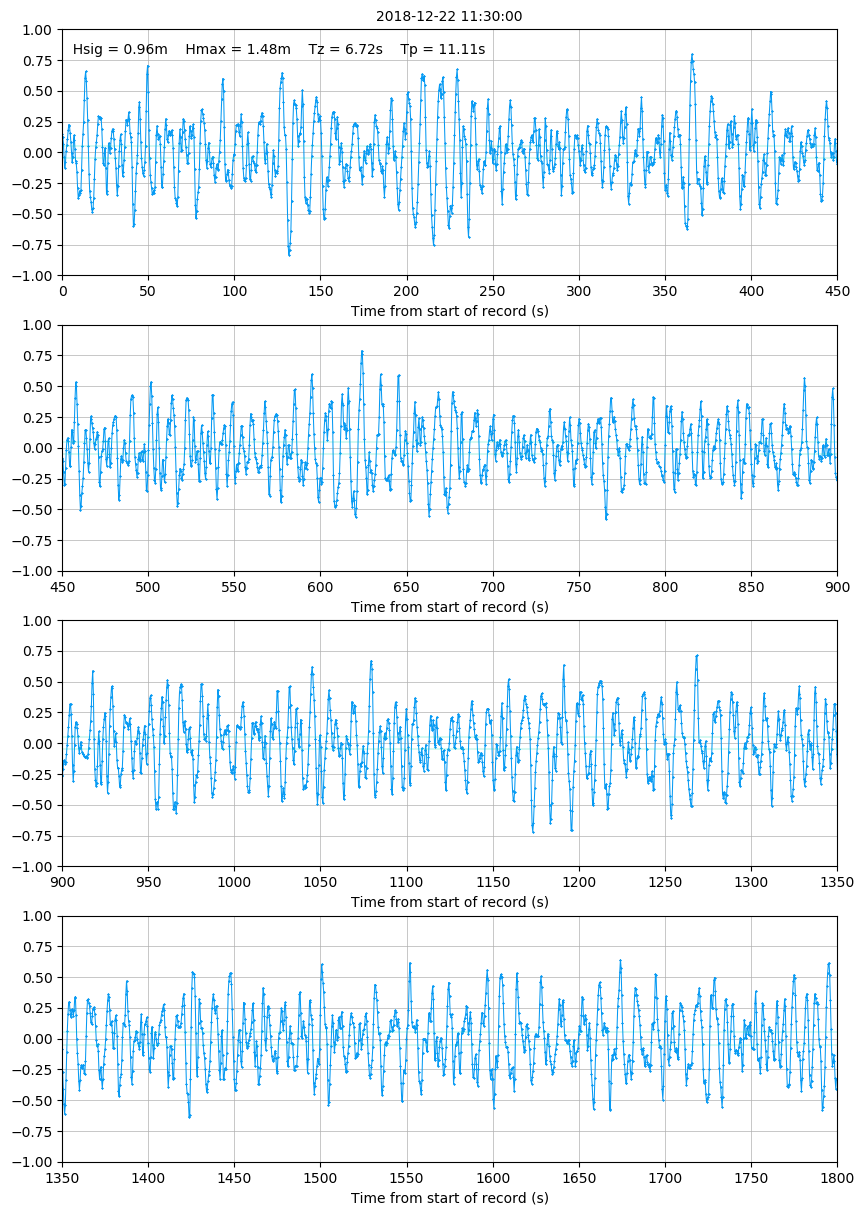

2018-12-22 11:30 Hs= 0.97 Ti= 8.70 Te= 8.13 T1= 6.44 Tz= 5.46 T3= 3.90 Tc= 2.89 Tp=11.11
2018-12-22 11:30 Hmax= 1.48 THmax= 8.06 Tmax=12.49 HTmax= 0.55 Hsrms= 0.92 Nw= 259 Nc= 519
---------------------------------------------------
2018-12-22 12:00 Number of samples =  4608
2018-12-22 12:00 Number of segments =    17
ALERT: Possible spikes in the data at times: [ 145.34 1373.74 1374.13 1509.7  1510.09 1596.83 1597.22 1599.96 1600.35
 1617.15 1617.54]
2018-12-22 12:00 Hsig=0.97  Hrms=0.69  Hmax=1.46  Tz=6.25  THsig=9.31  Tp=10.53 Tmax=12.58 Wave Num.=283     
2018-12-22 12:00 Hm0=0.99  Hrms=0.70  T01=6.15  T02 5.32  Tp=10.53
2018-12-22 12:00 Hs= 0.99 Ti= 8.15 Te= 7.59 T1= 6.12 Tz= 5.30 T3= 3.94 Tc= 3.00 Tp=10.53
2018-12-22 12:00 Hmax= 1.71 THmax=10.26 Tmax=11.95 HTmax= 1.03 Hsrms= 0.93 Nw= 288 Nc= 497
---------------------------------------------------
2018-12-22 12:30 Number of samples =  4608
2018-12-22 12:30 Number of segments =    17
ALERT: Possible spikes in the data at times: [409

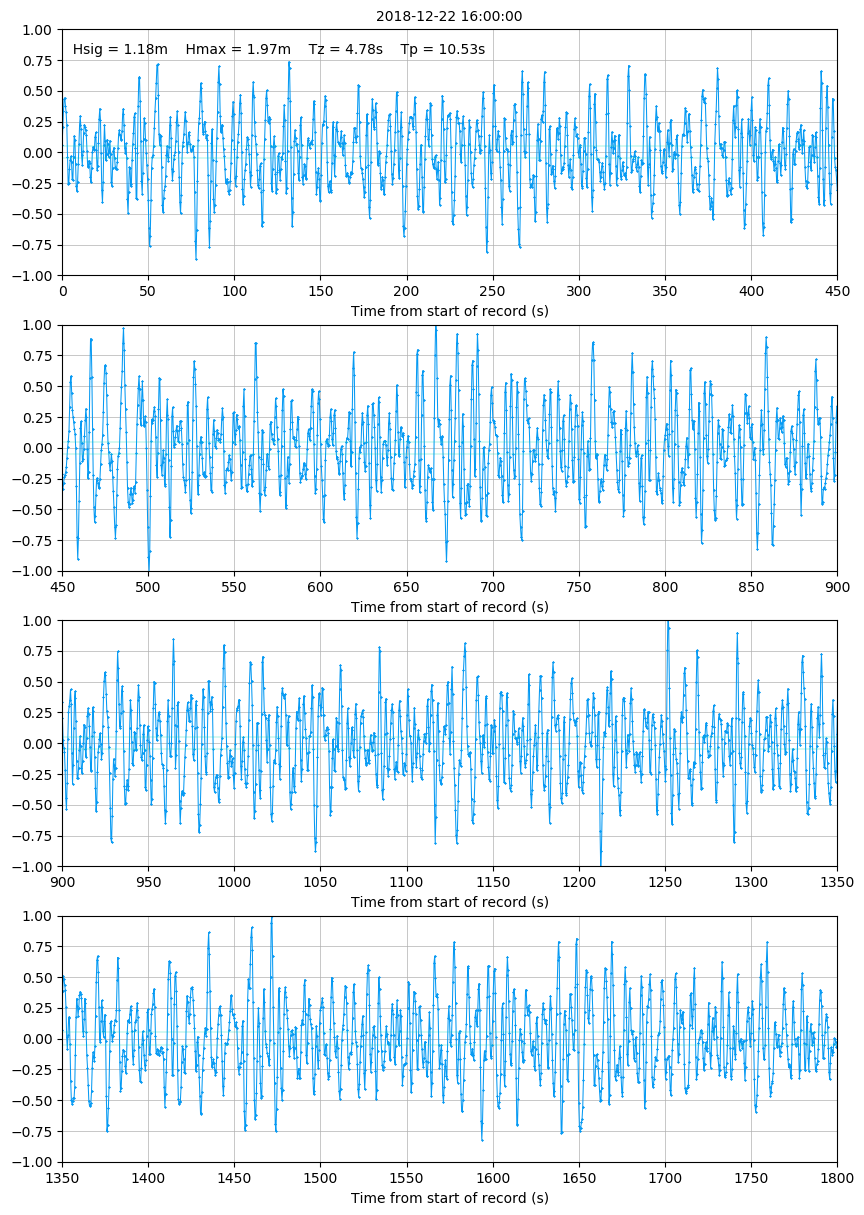

SystemExit: 

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [43]:
master = Tk()
colorama.init()

# Create a DT based on the structure type of the Datawell .BVA file format
BB1 = np.dtype([
    ('R0', 'B'),('R1', 'B'),('R2', 'B'),('R3', 'B'),('R4', 'B'),('R5', 'B'),('R6', 'B'),('R7', 'B'),('R8', 'B'),
    ('P9', 'B'),('P10', 'B'),('P11', 'B')
    ])

# Get name of input PRIM file
Input_BVA_File = get_file()

date_str = Input_BVA_File.split('/')[-1].split('.')[0]
Start_time = datetime.strptime(date_str, "%Y%m%d")
Next_time = Start_time; F20_time = Start_time; F23_time = datetime.now()

# Open file
#f = open(Input_BVA_File)
f = Input_BVA_File

# Read data from the Binary file into a DF based on the structure in the DT
print('Reading data from ',Input_BVA_File)
data = pd.DataFrame(np.fromfile(f, BB1))

# Convert the values into their Hex equivalents
data = data.applymap(lambda x:(repr(hex(x)).upper())[-3:-1])

# Need to make adjustment of Hex values less-than or equal-to 'F'
data = data.replace({'X'}, {'0'}, regex=True)

# Build the BVA format, minus the cyclically-counting line number
##Displacements_DF = '-'+data['R0']+data['R1']+data['R2']+data['R3']+data['R4']+data['R5']+data['R6']+data['R7']+data['R8']
##Packet_data_DF = '-'+data['P9']+data['P10']+data['P11']
Displacements_DF = data['R0']+data['R1']+data['R2']+data['R3']+data['R4']+data['R5']+data['R6']+data['R7']+data['R8']
Packet_data_DF = data['P9']+data['P10']+data['P11']

# Transform DF's into Lists
Displacements_List = []; Packet_List = []
print('Building Displacement data array')
Displacements_List = ['-' + s for s in Displacements_DF.tolist()]
Packet_List = ['-' + s for s in Packet_data_DF.tolist()]

Packet_data = []
print('Building Packet data array')
for val in Packet_List:
    Packet_data.append(val[1:3])
    Packet_data.append(val[3:5])
    Packet_data.append(val[5:7])

# Locate occurrences of 0x7E's in Packet_data - Refer to DWTP 2.1.2 p.21
print('Locating occurrences of 0x7E in Packet data')
Valu_0x7E_List = [i for i, j in enumerate(Packet_data) if j == '7E']

# Get the bytes between respective '7E' values - ignoring where consecutive '7E' values exist
fk = []; s_tilde = []; dirn = []; spread = []
for i in range(len(Valu_0x7E_List)-1):
    start = Valu_0x7E_List[i]+1; end = Valu_0x7E_List[i+1]
    if end-start > 1:
        Decoded = Packet_data[start:end]
        
        Found_7D = [m for m, n in enumerate(Decoded) if n == '7D']        # Locate '7D' in packet

        for p in range(len(Found_7D)):
            XOred = hex(int(Decoded[Found_7D[p]+1],16)^int('20',16))      # X'Or the byte after '7D'
            Decoded[Found_7D[p]+1] = XOred[2:].upper()

        for p in range(len(Found_7D)-1,-1,-1): 
            del Decoded[Found_7D[p]]                                      # Remove this '7D' from the packet
            
        Message_Id = Decoded[0][0]+Decoded[1]; CRC_4_Checksum = Decoded[0][1]

        if (Message_Id == 'F25'): 
            F25_time,Hs,Ti,Te,T1,Tz,T3,Tc,Tp = Do_F25(Decoded)            # Decode Directional Spectral Parameters message
            
        if (Message_Id == 'F26'): 
            F26_time,Hmax,THmax,Tmax,HTmax,Hsrms,Nw,Nc = Do_F26(Decoded)  # Decode online upcrossing wave statistics message                    
    
        if (Message_Id == 'F20'):
            F20_time,s_tilde,Smax,No_of_segments = Do_F20(Decoded)                       # Decode Heave spectrum message
            fk = calc_frequencies()

        if (Message_Id == 'F23'): 
            F23_time,Match_vector,Sample_number,Hn_1_sign,Nn_1_sign,Wn_1_sign,Hn_sign,Nn_sign,Wn_sign = Do_F23(Decoded)          # Decode Spectrum synchronisation message

        if (Message_Id == 'F29'): Do_F29(Decoded)
            
        if (F20_time == F23_time):
            if (F20_time >= Next_time):   # Indicates at least one record has been missed
                Position = [i for i, j in zip(count(), Displacements_List) if j == '-'+Match_vector]
                if len(Position) > 0:     # Get the WL's, and Displacements in North and West
                    
                    print('{:%Y-%m-%d %H:%M}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}' \
                        .format(F25_time,' Hs=',Hs,' Ti=',Ti,' Te=',Te,' T1=',T1,' Tz=',Tz,' T3=',T3,' Tc=',Tc,' Tp=',Tp))

                    print('{:%Y-%m-%d %H:%M}{:6s}{:5.2f}{:7s}{:5.2f}{:6s}{:5.2f}{:7s}{:5.2f}{:7s}{:5.2f}{:4s}{:4d}{:4s}{:4d}' \
                        .format(F26_time,' Hmax=',Hmax,' THmax=',THmax,' Tmax=',Tmax,' HTmax=',HTmax,' Hsrms=',Hsrms,' Nw=',Nw,' Nc=',Nc))
                    
                    Status = []; wls = []; north = []; west = []
                    Get_Displacements(Position,Sample_number, Status, Displacements_List, wls, north, west)
                    Record_time = F20_time  # Pass Record_time to the Calc_parameters cell

                    print('---------------------------------------------------')
                    print('{:%Y-%m-%d %H:%M}{:21s}{:5d}'.format(Record_time,' Number of samples = ',Sample_number))
                    print('{:%Y-%m-%d %H:%M}{:22s}{:5d}'.format(Record_time,' Number of segments = ',No_of_segments))

# Check for consecutive values the same - to detect an accelerometer fault.
# Suggested value for this check is 11 (4.3s)
                    wls_around = np.around(wls,decimals=2)
                    num_of_consecutive_values_same = max(len(list(v)) for g,v in itertools.groupby(wls_around))
                    if num_of_consecutive_values_same > 4:
                        print('Warning: There are ',num_of_consecutive_values_same,' consecutive points with the same value!')
                    
                    Next_time = F20_time + timedelta(seconds=4608/2.56)
                                             
                    f_Mk4 = calc_frequencies()    # calculate frequency values for the Mk4 wave buoy
                    f2,Pden2,Tp2 = calc_spectral_parameters(wls)
                    Below,Hmean,Hsig,Hmax,Tz,THsig,Tp2,Tmax,waves,spikes = Do_time_domain(wls,F20_time,Tp2)
                    Hm0,Hrms,T01,T02,Tp,Fp = get_parameters_Mk4(f_Mk4,s_tilde,F20_time)
                    Do_error_checks(wls,Hsig,Hmax,Hrms,Hm0,THsig,T02,Tz,Tp,Tmax)
                        
                    MyButton1 = Button(master, text='Plot waves',font=('Sans','12','bold'),height=2,width=30, \
                                       command=lambda:Plot_wls(wls,Below,Hsig,Hmax,Tz,Tp2,F20_time,spikes))
                    MyButton1.grid(row=0, column=0)

                    MyButton2 = Button(master, text='Heave-North-West',font=('Sans','12','bold'),height=2,width=30, \
                                       command=lambda:Plot_heave_north_west(wls,north,west,Hsig,Hmax,Tz,Tp2,Record_time,spikes))
                    MyButton2.grid(row=1, column=0)

                    MyButton3 = Button(master, text='Spectra',font=('Sans','12','bold'),height=2,width=30, \
                                       command=lambda:Plot_spectra(f_Mk4,s_tilde,f2,Pden2,F20_time,Hm0,Hrms,T01,T02,Tp,Fp))
                    MyButton3.grid(row=2, column=0)

                    MyButton4 = Button(master, text='Histogram',font=('Sans','12','bold'),height=2,width=30, \
                                       command=lambda:Do_Histogram(wls,F20_time))
                    MyButton4.grid(row=3, column=0)

                    MyButton5 = Button(master, text='Velocity Plot',font=('Sans','12','bold'),height=2,width=30, \
                                       command=lambda:Plot_velocities(wls))
                    MyButton5.grid(row=4, column=0)

                    MyButton6 = Button(master, text='Rayleigh',font=('Sans','12','bold'),height=2,width=30, \
                                       command=lambda:Do_Rayleigh(waves,F20_time,Hsig,Hrms,Hmax))
                    MyButton6.grid(row=5, column=0)

                    MyButton7 = Button(master, text='2d Plot',font=('Sans','12','bold'),height=2,width=30, \
                                       command=lambda:Do_polar(wls,north,west,F20_time))
                    MyButton7.grid(row=6, column=0)

                    MyButton8 = Button(master, text='3d Plot',font=('Sans','12','bold'),height=2,width=30, \
                                       command=lambda:Do_3d(wls,north,west,F20_time))
                    MyButton8.grid(row=7, column=0)

                    MyButton9 = Button(master, text='Continue',font=('Sans','12','bold'),height=2,width=30, \
                                       command=master.quit)
                    MyButton9.grid(row=8, column=0)

                    MyButton10 = Button(master, text='QUIT',font=('Sans','12','bold'),fg='red',height=2,width=30, \
                                        command=lambda:finished())
                    MyButton10.grid(row=9, column=0)

                    master.mainloop()
                                        
                else:
                    Next_time = F20_time + timedelta(seconds=4608/2.56)
    